In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes
import pandas as pd
import yfinance as yf
import requests
from datetime import datetime

# Define the time period
start_date = '1987-05-20'
end_date = '2015-01-05'

# Fetching Dow Jones Industrial Average (DJI) data from Yahoo Finance
dji = yf.download('^DJI', start=start_date, end=end_date)
dji = dji['Adj Close']
dji = list(dji)


# Simulated Dow Jones data for demonstration
# Replace this with actual Dow Jones time-series data
np.random.seed(42)
dow_jones_data = dji

# Function to divide time-series data into sliding windows
def sliding_windows(data, window_size):
    return [data[i:i+window_size] for i in range(len(data) - window_size + 1)]

# Function to calculate generalized correlation coefficient
def generalized_correlation(X, Y, q):
    gq = lambda z: np.sign(z) * np.abs(z)**q
    Uq_XY = np.mean([gq(X[i] - X[j]) * gq(Y[i] - Y[j]) for i in range(len(X)) for j in range(i+1, len(X))])
    Uq_XX = np.mean([gq(X[i] - X[j])**2 for i in range(len(X)) for j in range(i+1, len(X))])
    Uq_YY = np.mean([gq(Y[i] - Y[j])**2 for i in range(len(Y)) for j in range(i+1, len(Y))])
    return Uq_XY / np.sqrt(Uq_XX * Uq_YY)

# Generate MDS map for a given distance matrix
def generate_mds_map(dist_matrix, n_components=2):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    return mds.fit_transform(dist_matrix)

# Apply Procrustes analysis to superimpose MDS maps
def procrustes_analysis(mds_maps):
    reference_map = mds_maps[0]
    transformed_maps = [reference_map]
    for mds_map in mds_maps[1:]:
        _, mtx = orthogonal_procrustes(reference_map, mds_map)
        transformed_maps.append(mds_map.dot(mtx))
    return np.mean(transformed_maps, axis=0)

# Step 1: Divide the data into sliding windows
window_size = 300
windows = sliding_windows(dow_jones_data, window_size)

# Step 2: Calculate similarity matrices using generalized correlation index with different q values
q_values = np.linspace(0.1, 1.2, 10)
similarity_matrices = []
for q in q_values:
    dist_matrix = squareform(pdist(windows, metric=lambda X, Y: generalized_correlation(X, Y, q)))
    similarity_matrices.append(dist_matrix)

# Step 3: Generate MDS maps for each similarity matrix
mds_maps_2d = [generate_mds_map(dist_matrix, n_components=2) for dist_matrix in similarity_matrices]
mds_maps_3d = [generate_mds_map(dist_matrix, n_components=3) for dist_matrix in similarity_matrices]

# Step 4: Apply Procrustes analysis to superimpose MDS maps
final_mds_map_2d = procrustes_analysis(mds_maps_2d)
final_mds_map_3d = procrustes_analysis(mds_maps_3d)

# Plot the final MDS maps
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 2D MDS Map
axes[0].scatter(final_mds_map_2d[:, 0], final_mds_map_2d[:, 1])
axes[0].set_title('MDS Map (2D)')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

# 3D MDS Map
axes[1] = plt.subplot(122, projection='3d')
axes[1].scatter(final_mds_map_3d[:, 0], final_mds_map_3d[:, 1], final_mds_map_3d[:, 2])
axes[1].set_title('MDS Map (3D)')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].set_zlabel('Dimension 3')

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed


/Users/zeynahshiri/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/zeynahshiri/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/zeynahshiri/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/zeynahshiri/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version

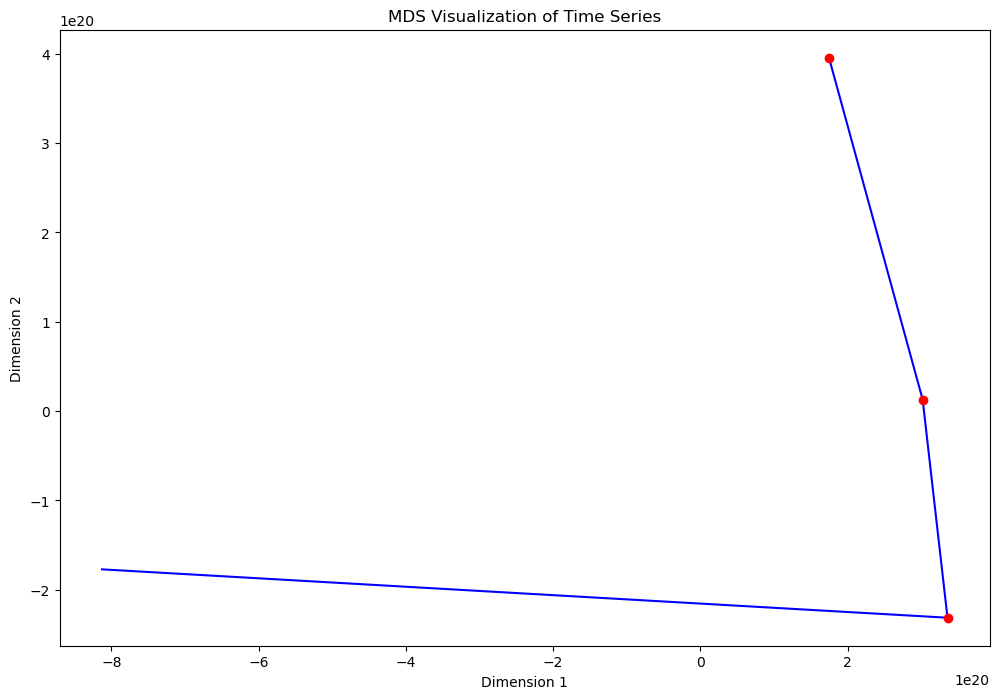

In [5]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def generalized_correlation(X, Y, q):
    n = len(X)
    gX = np.sign(X[:, None] - X) * np.abs(X[:, None] - X)**q
    gY = np.sign(Y[:, None] - Y) * np.abs(Y[:, None] - Y)**q
    
    Uq_XY = 2 / (n * (n-1)) * np.sum(gX * gY)
    Uq_XX = 2 / (n * (n-1)) * np.sum(gX**2)
    Uq_YY = 2 / (n * (n-1)) * np.sum(gY**2)
    
    return Uq_XY / np.sqrt(Uq_XX * Uq_YY)

def minkowski_distance(X, Y, q):
    return np.sum(np.abs(X - Y)**q)**(1/q)

def sliding_window(data, window_size):
    return np.array([data[i:i+window_size] for i in range(0, len(data)-window_size+1, window_size)])

def calculate_similarity_matrix(windows, q, similarity_func):
    n_windows = len(windows)
    similarity_matrix = np.zeros((n_windows, n_windows))
    
    for i in range(n_windows):
        for j in range(i, n_windows):
            similarity = similarity_func(windows[i], windows[j], q)
            similarity_matrix[i, j] = similarity_matrix[j, i] = similarity
    
    return similarity_matrix

def mds_visualization(similarity_matrices, n_components=2):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    mds_results = [mds.fit_transform(1 - matrix) for matrix in similarity_matrices]
    return mds_results

def simple_procrustes(X, Y):
    """
    A simple Procrustes analysis without scaling.
    """
    muX = X.mean(0)
    muY = Y.mean(0)
    
    X0 = X - muX
    Y0 = Y - muY
    
    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()
    
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)
    
    X0 /= normX
    Y0 /= normY
    
    A = np.dot(X0.T, Y0)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)
    
    return np.dot(Y0, T) * normX + muX

def procrustes_analysis(mds_results):
    reference = mds_results[0]
    aligned_results = [reference]
    
    for result in mds_results[1:]:
        transformed = simple_procrustes(reference, result)
        aligned_results.append(transformed)
    
    return np.mean(aligned_results, axis=0)

# Load and preprocess data
data = pd.read_excel('GDP.xlsx')  # Replace with your data
time_series = data['GDP'].values

# Parameters
window_size = 50
q_values = np.linspace(0.1, 2, 20)

# Sliding window
windows = sliding_window(time_series, window_size)

# Calculate similarity matrices
similarity_matrices = [calculate_similarity_matrix(windows, q, minkowski_distance) for q in q_values]

# MDS visualization
mds_results = mds_visualization(similarity_matrices, n_components=2)

# Procrustes analysis
global_map = procrustes_analysis(mds_results)

# Plotting
plt.figure(figsize=(12, 8))
for i in range(len(global_map) - 1):
    plt.plot([global_map[i, 0], global_map[i+1, 0]], [global_map[i, 1], global_map[i+1, 1]], 'b-')
    plt.plot(global_map[i, 0], global_map[i, 1], 'ro')

plt.title('MDS Visualization of Time Series')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

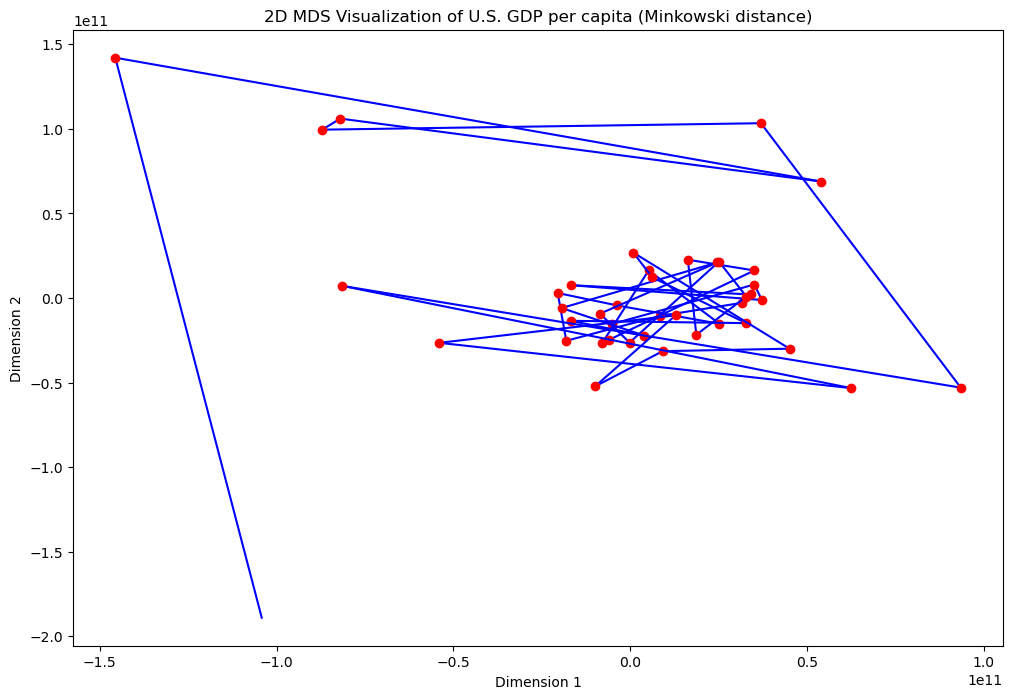

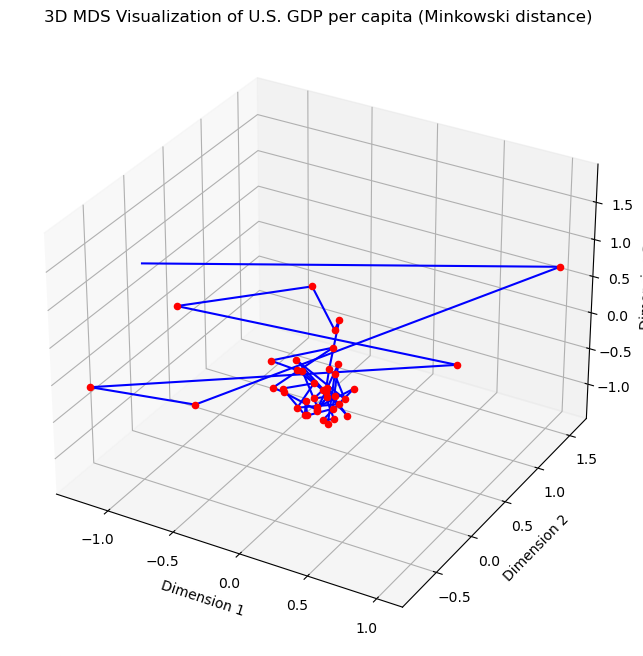

In [6]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def minkowski_distance(X, Y, q):
    return np.sum(np.abs(X - Y)**q)**(1/q)

def sliding_window(data, window_size):
    return np.array([data[i:i+window_size] for i in range(0, len(data)-window_size+1, window_size)])

def calculate_similarity_matrix(windows, q, similarity_func):
    n_windows = len(windows)
    similarity_matrix = np.zeros((n_windows, n_windows))
    
    for i in range(n_windows):
        for j in range(i, n_windows):
            similarity = similarity_func(windows[i], windows[j], q)
            similarity_matrix[i, j] = similarity_matrix[j, i] = similarity
    
    return similarity_matrix

def mds_visualization(similarity_matrices, n_components):
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
    mds_results = [mds.fit_transform(1 - matrix) for matrix in similarity_matrices]
    return mds_results

def simple_procrustes(X, Y):
    muX = X.mean(0)
    muY = Y.mean(0)
    
    X0 = X - muX
    Y0 = Y - muY
    
    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()
    
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)
    
    X0 /= normX
    Y0 /= normY
    
    A = np.dot(X0.T, Y0)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)
    
    return np.dot(Y0, T) * normX + muX

def procrustes_analysis(mds_results):
    reference = mds_results[0]
    aligned_results = [reference]
    
    for result in mds_results[1:]:
        transformed = simple_procrustes(reference, result)
        aligned_results.append(transformed)
    
    return np.mean(aligned_results, axis=0)

# Load and preprocess data
data = pd.read_excel('GDP.xlsx')
time_series = data.iloc[:, 1].values  # Assuming the GDP values are in the second column

# Parameters
window_size = 5  # Adjust this based on your data
q_values = np.linspace(0.1, 2, 20)

# Sliding window
windows = sliding_window(time_series, window_size)

# Calculate similarity matrices
similarity_matrices = [calculate_similarity_matrix(windows, q, minkowski_distance) for q in q_values]

# MDS visualization and Procrustes analysis for 2D and 3D
for n_components in [2, 3]:
    mds_results = mds_visualization(similarity_matrices, n_components=n_components)
    global_map = procrustes_analysis(mds_results)

    # Plotting
    if n_components == 2:
        plt.figure(figsize=(12, 8))
        for i in range(len(global_map) - 1):
            plt.plot([global_map[i, 0], global_map[i+1, 0]], [global_map[i, 1], global_map[i+1, 1]], 'b-')
            plt.plot(global_map[i, 0], global_map[i, 1], 'ro')
        plt.title(f'2D MDS Visualization of U.S. GDP per capita (Minkowski distance)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
    else:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        for i in range(len(global_map) - 1):
            ax.plot([global_map[i, 0], global_map[i+1, 0]], 
                    [global_map[i, 1], global_map[i+1, 1]], 
                    [global_map[i, 2], global_map[i+1, 2]], 'b-')
            ax.scatter(global_map[i, 0], global_map[i, 1], global_map[i, 2], c='r', marker='o')
        ax.set_title(f'3D MDS Visualization of U.S. GDP per capita (Minkowski distance)')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')

    plt.show()

/var/folders/1t/8n2qjs5163vcqsyv37syfg2m0000gn/T/ipykernel_7374/2024597453.py:69: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[1] = plt.subplot(122, projection='3d')


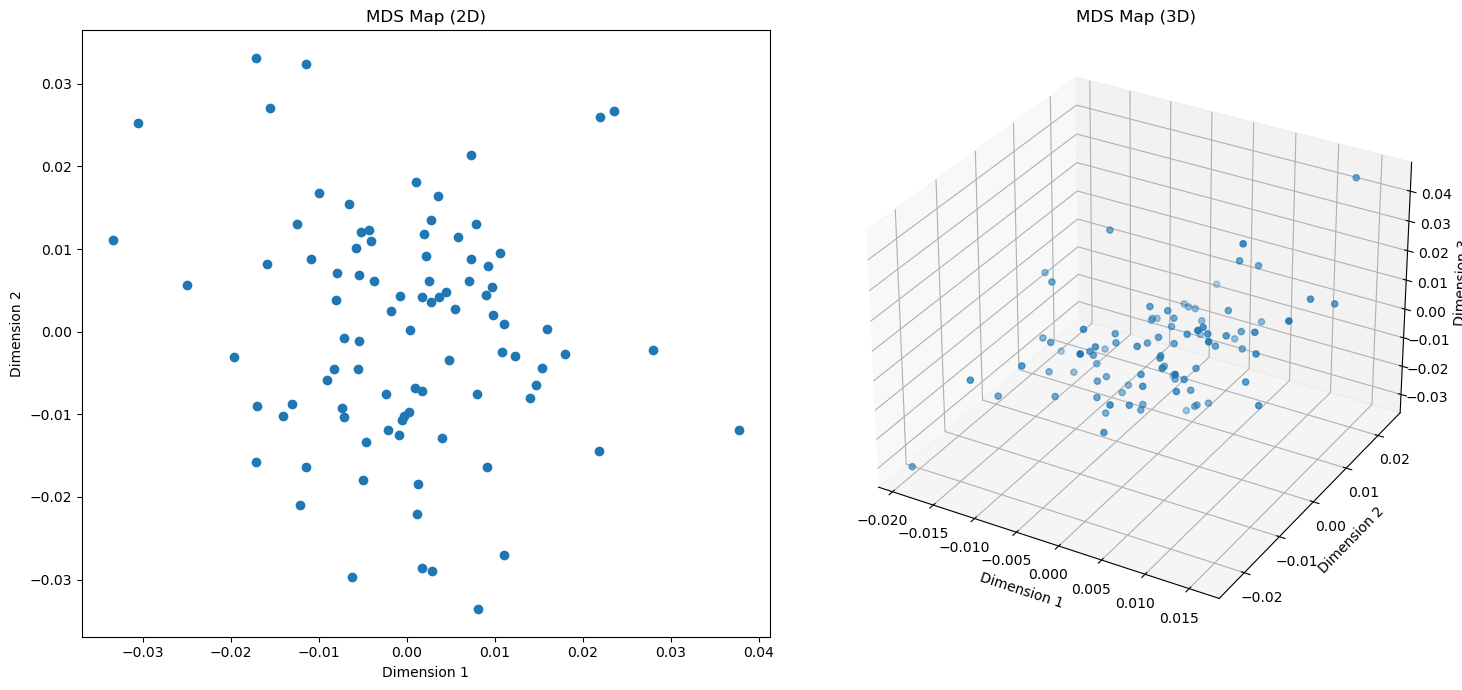

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes

# Simulated Dow Jones data for demonstration
# Replace this with actual Dow Jones time-series data
np.random.seed(42)
dow_jones_data = np.random.randn(100)

# Function to divide time-series data into sliding windows
def sliding_windows(data, window_size):
    return [data[i:i+window_size] for i in range(len(data) - window_size + 1)]

# Function to calculate generalized correlation coefficient
def generalized_correlation(X, Y, q):
    gq = lambda z: np.sign(z) * np.abs(z)**q
    Uq_XY = np.mean([gq(X[i] - X[j]) * gq(Y[i] - Y[j]) for i in range(len(X)) for j in range(i+1, len(X))])
    Uq_XX = np.mean([gq(X[i] - X[j])**2 for i in range(len(X)) for j in range(i+1, len(X))])
    Uq_YY = np.mean([gq(Y[i] - Y[j])**2 for i in range(len(Y)) for j in range(i+1, len(Y))])
    return Uq_XY / np.sqrt(Uq_XX * Uq_YY)

# Generate MDS map for a given distance matrix
def generate_mds_map(dist_matrix, n_components=2):
    # Modify MDS initialization to suppress warnings
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, normalized_stress='auto')

    return mds.fit_transform(dist_matrix)

# Apply Procrustes analysis to superimpose MDS maps
def procrustes_analysis(mds_maps):
    reference_map = mds_maps[0]
    transformed_maps = [reference_map]
    for mds_map in mds_maps[1:]:
        _, mtx = orthogonal_procrustes(reference_map, mds_map)
        transformed_maps.append(mds_map.dot(mtx))
    return np.mean(transformed_maps, axis=0)

# Step 1: Divide the data into sliding windows
window_size = 10
windows = sliding_windows(dow_jones_data, window_size)

# Step 2: Calculate similarity matrices using generalized correlation index with different q values
q_values = np.linspace(0.1, 1.2, 10)
similarity_matrices = []
for q in q_values:
    dist_matrix = squareform(pdist(windows, metric=lambda X, Y: generalized_correlation(X, Y, q)))
    similarity_matrices.append(dist_matrix)

# Step 3: Generate MDS maps for each similarity matrix
mds_maps_2d = [generate_mds_map(dist_matrix, n_components=2) for dist_matrix in similarity_matrices]
mds_maps_3d = [generate_mds_map(dist_matrix, n_components=3) for dist_matrix in similarity_matrices]

# Step 4: Apply Procrustes analysis to superimpose MDS maps
final_mds_map_2d = procrustes_analysis(mds_maps_2d)
final_mds_map_3d = procrustes_analysis(mds_maps_3d)

# Plot the final MDS maps
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 2D MDS Map
axes[0].scatter(final_mds_map_2d[:, 0], final_mds_map_2d[:, 1])
axes[0].set_title('MDS Map (2D)')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

# 3D MDS Map
axes[1] = plt.subplot(122, projection='3d')
axes[1].scatter(final_mds_map_3d[:, 0], final_mds_map_3d[:, 1], final_mds_map_3d[:, 2])
axes[1].set_title('MDS Map (3D)')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].set_zlabel('Dimension 3')

plt.tight_layout()
plt.show()
